In [1]:
%load_ext autoreload
%autoreload 2
%load_ext blackcellmagic

## Synthetic Data Experiment

<br>
<b>Description</b> : This notebook evaluates the interaction model on synthetic data<br>
<b>Author</b> : Alma Andersson (andera29@gene.com)<br>
<b>Date</b> : 08/14/2024

In [9]:
import tangram2 as tg2
import anndata as ad 
import numpy as np
import scanpy as sc

import os
import os.path as osp
import shutil

from itertools import product
import pandas as pd
import matplotlib.pyplot as plt

### Set variables

In [16]:
with open('OUTPUT_DIR.txt','r+') as f:
    OUTPUT_ROOT = f.readlines()[0]

OUTPUT_DIR = osp.join(OUTPUT_ROOT, 'synthetic')
os.makedirs(OUTPUT_DIR, exist_ok = True)

## Helper Functions

In [3]:
def read_h5ad_uniqify(path,tag = None):
    adata = ad.read_h5ad(path)
    adata.obs_names_make_unique()
    adata.var_names_make_unique()
    if tag is not None:
        adata.obs_names  = [f'{tag}_{x}' for x in adata.obs_names]
    return adata

In [4]:
def pp_adata(ad_sc, ad_sp=None):
    is_mt = ad_sc.var_names.str.startswith("MT-")
    is_rp = ad_sc.var_names.str.startswith(("RPS", "RPL", "RP-", "RP"))
    keep_genes = (~is_mt) & (~is_rp)
    ad_sc = ad_sc[:, keep_genes].copy()

    sc.pp.filter_cells(ad_sc, min_counts=300)

    sc.pp.filter_genes(ad_sc, min_counts=10)

    if ad_sp is not None:
        sc.pp.filter_cells(ad_sp, min_counts=100)
        sc.pp.filter_genes(ad_sp, min_counts=10)

    ad_sc.layers["raw"] = ad_sc.X.copy()
    sc.pp.normalize_total(ad_sc, 1e4)
    sc.pp.log1p(ad_sc)
    sc.pp.highly_variable_genes(ad_sc, n_top_genes=5000)
    ad_sc.layers["norm"] = ad_sc.X.copy()
    ad_sc.X = ad_sc.layers["raw"].copy()

    if ad_sp is not None:
        return ad_sc, ad_sp
    return ad_sc

## Load data

## Evaluation on Synthetic Data

Here we will run the InterGram (Tg2 + Interaction Model) model on synthetic data with different hyperparameters for the synthetic data generation. This allows us to test how the method works in different conditions (e.g., when the effect genes are lowly/highly expressed in general, when the interaction effect is strong, the direction of the effect etc.) 

### Synthetic Data Generation | Explanation

We are using the cellmix module of telegraph to generate the synthetic data. We provide a simplified explanation of the procedure below, please see the documenation for a full description.

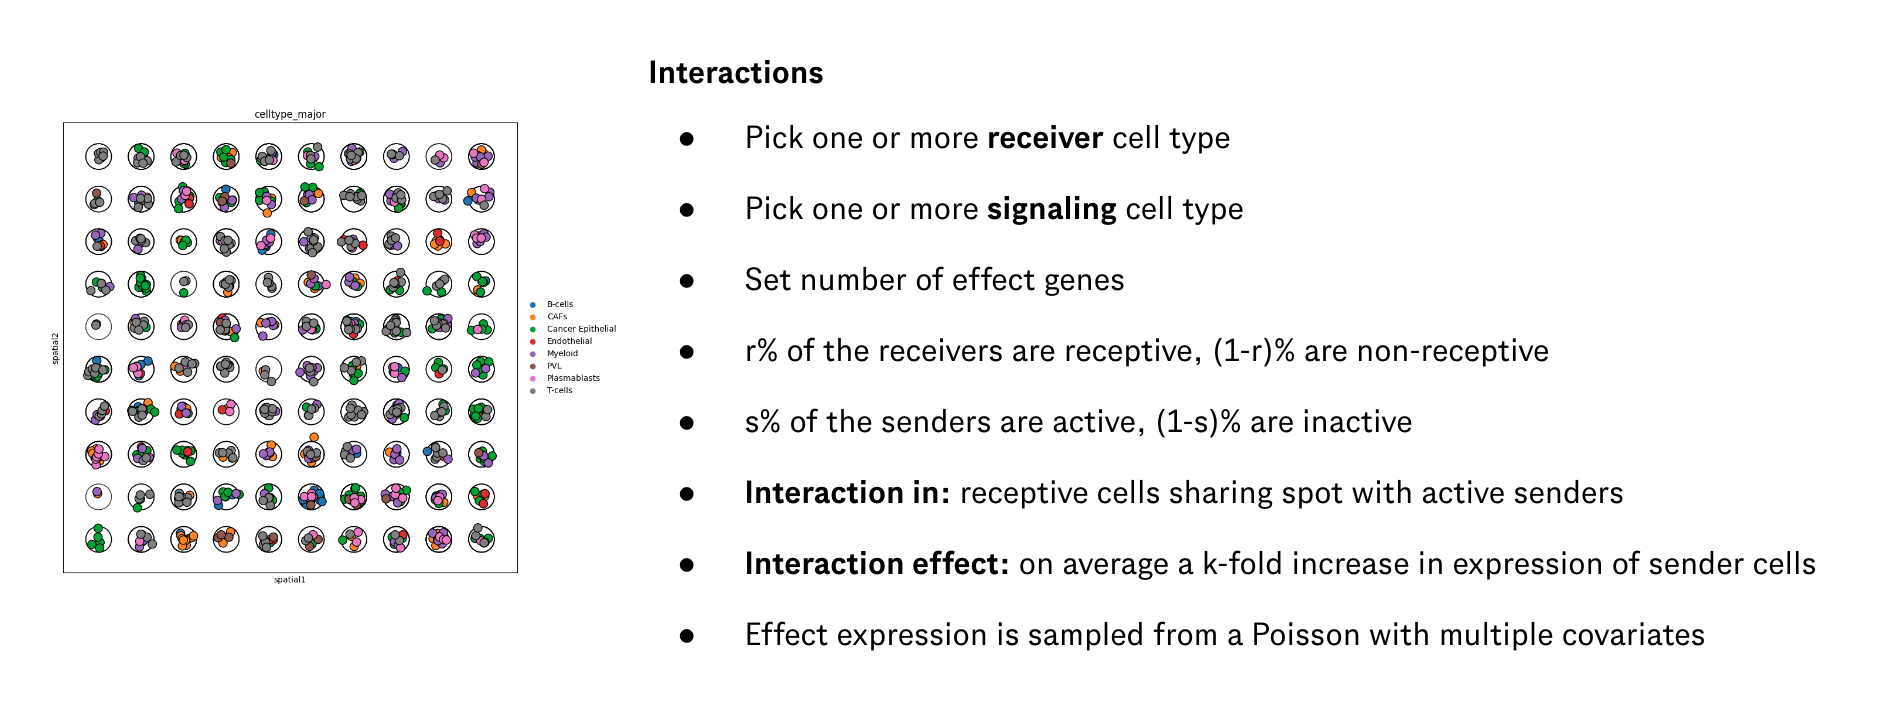

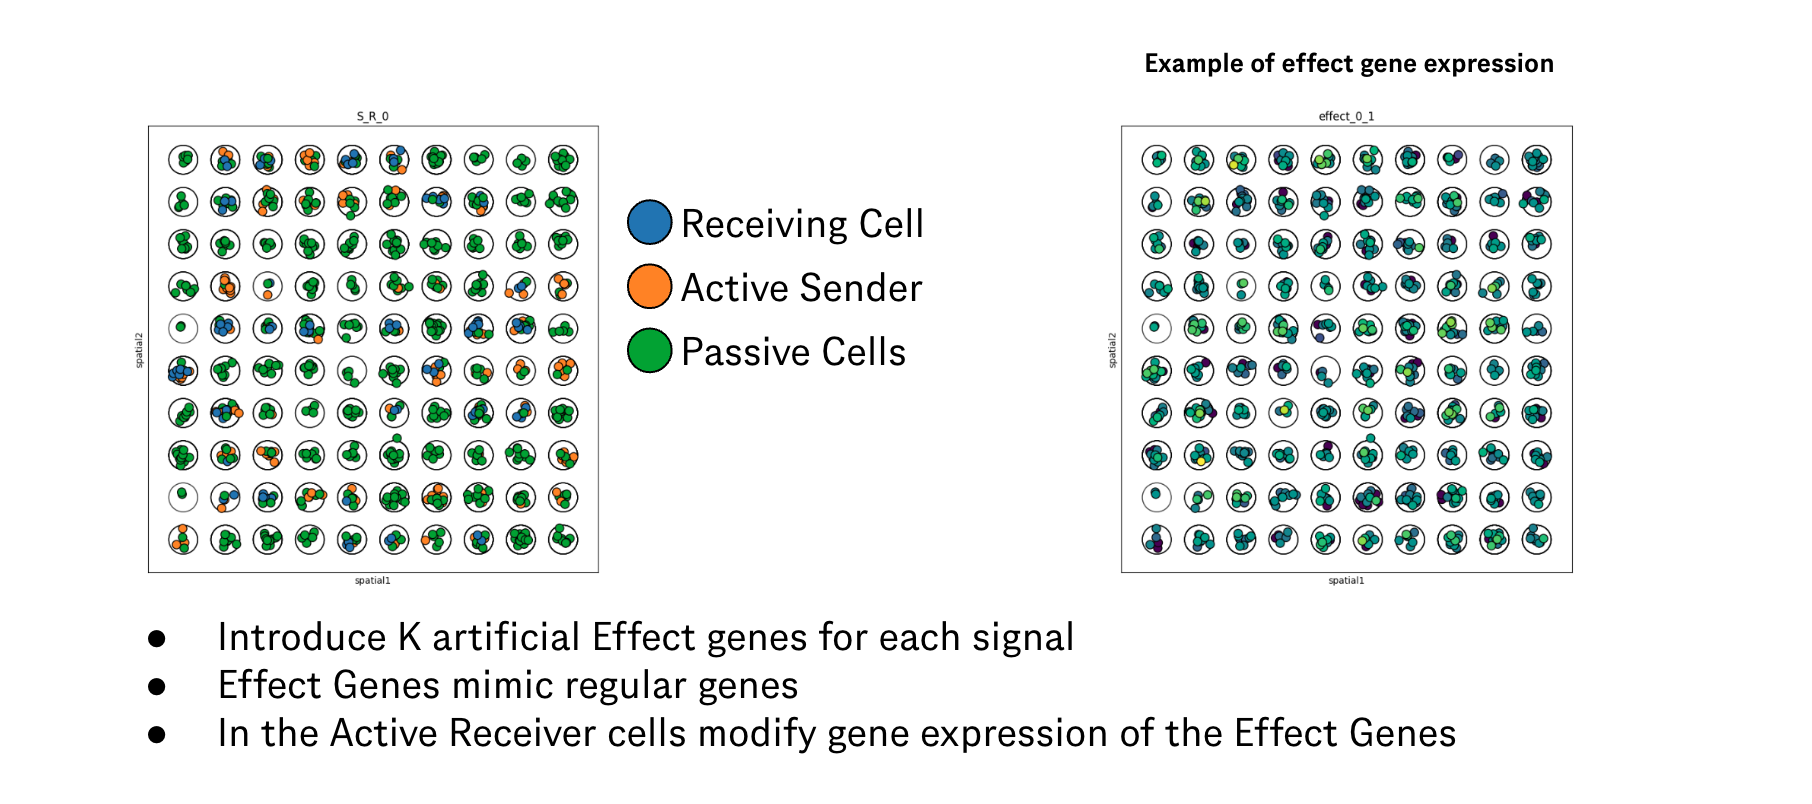

Specify path to the single cell data used to create the synthetic data

In [5]:
SC_PTH = '../../data/synth_analysis/CID4465_sc.h5ad'

Load data

In [6]:
adata = ad.read_h5ad(SC_PTH)

Define cell type column in `adata.obs`

In [7]:
label_col = 'celltype_major'

Set receiver and signaling cell types 

In [8]:
receiver_name, signaler_name = adata.obs[label_col].value_counts().index[0:2]

Specify the different hyperparameters to iterate over. <br>
<br>
**NOTE** : The hyperparameters are for the synthetic data generation, not the method.

In [3]:
# direction of effects
ef_dirs = ["up", "down"]
# effect strength
signal_effect_scaling = [1.5, 2, 3, 5]
# baseline expression (quantile) of effect genes in non-interacting cells
signal_effect_base = [0.5, 0.8, 0.95, 0.99]
# number of spots
n_spots = [100, 250, 500]
# number of genes in the downstream effect
n_effects = [10, 25, 50]

### Run the analysis

In [2]:
# dictionary to store the results
res_dict = dict(
    effect_direction=[],
    effect_scaling=[],
    effect_base=[],
    n_spots=[],
    n_effect_genes=[],
    score=[],
)

# number of replicates of each hyperparam combination
n_reps = 3
# variable to store seed
seed = 0

# iterate over replcicates
for _ in range(n_reps):
    # get data generation hyperparameter combination
    combs = product(
        ef_dirs, signal_effect_scaling, signal_effect_base, n_spots, n_effects
    )

    for (edir, scaling, base, spots, nef) in combs:
        # update seed value
        seed += 1
        # set random seed
        np.random.seed(seed)

        # generate synthetic data
        ad_sp, ad_sc = tg2.evalkit.datagen.cellmix.cellmix.cellmix(
            adata.copy(),
            n_spots=spots,
            n_cells_per_spot=10,
            n_types_per_spot=5,
            label_col=label_col,
            signaler_names=signaler_name,
            receiver_names=receiver_name,
            n_interactions=1,
            effect_size=nef,
            effect_direction=edir,
            signal_effect_base=base,
            signal_effect_scaling=scaling,
            p_inter=0.8,
            p_signal_spots=0.9,
        )

        # preprocess data
        ad_sc = pp_adata(ad_sc)

        # -- Tangram2 Step  -- #

        # get highly variable genes
        hvg_genes = ad_sc.var_names[ad_sc.var.highly_variable.values].tolist()

        # configure state_dict for telegraph
        input_dict_1 = tg2.evalkit.met.utils.adatas_to_input(
            {"from": ad_sc.copy(), "to": ad_sp.copy()},  # provide the data to be used
            categorical_labels={
                "from": [label_col]
            },  # include cluster labels in the design matrix
        )

        # preprocess
        tg2.evalkit.met.pp.StandardTangram2.run(input_dict_1)

        # map data
        map_res_1 = tg2.evalkit.met.map_methods.Tangram2Map.run(
            input_dict_1,
            num_epochs=1000,
            genes=hvg_genes,
        )
        # update state dict with result
        input_dict_1.update(map_res_1)

        # -- Interaction Inference Step  -- #

        # normalize data
        sc.pp.normalize_total(input_dict_1["X_from"], target_sum=1e4)
        sc.pp.log1p(input_dict_1["X_from"])

        # run interaction model
        inter_res = tg2.ccc.TangramCCC.run(
            input_dict_1, n_epochs=1000, seed=k, verbose=False
        )

        # get interaction coefficients
        beta = inter_res["beta"].to_dataframe()["beta"]

        # get specific receier-signaler interaction coefficients and sort
        scores = beta.loc[receiver_name, signaler_name].sort_values(ascending=False)
        scores = pd.DataFrame(scores, columns=["beta"])
        scores["names"] = scores.index

        # get the names of the artifically introduced effect genes (GT)
        effect = [x for x in ad_sc.var.index if x.startswith("effect_")]

        # compute AUROC score between interaction scores and GT
        score = tg2.evalkit.dig.dea.compute_dea_score(
            scores,
            effect=effect,
            score_by="beta",
            method="auroc",
            reverse=(edir == "down"),
        )

        # update results
        res_dict["effect_direction"].append(edir)
        res_dict["effect_scaling"].append(scaling)
        res_dict["effect_base"].append(base)
        res_dict["n_spots"].append(spots)
        res_dict["n_effect_genes"].append(nef)
        res_dict["score"].append(score["score"])

save results

In [ ]:
res = pd.DataFrame(res_dict)

In [12]:
res.to_csv(osp.join(OUTPUT_DIR,'results.csv'))